# **Movie Reviews Sentiment Analysis**

# Load necessary libraries

In [1]:
# install modules if working on local machine
#!pip install tensorflow
#!pip install wordcloud
#!pip install nltk

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Zucch\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zucch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zucch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zucch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Zucch\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Import dataset

Run the following code if working on Colab (takes 8-10 min !)

In [2]:
# Upload the local data file to colab
#from google.colab import files
#uploaded = files.upload()

# Explore the dataset

The dataset contains 50'000 highly polar movie reviews which are classified as positive or negative.

In [3]:
df = pd.read_csv('Reviews Dataset.csv')
print('The data shape is:', df.shape)
df.head(5) #preview the first 5 rows

The data shape is: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


We can observe the dataset is equally balanced between positive and negative reviews (25'000 each).

In [4]:
df.groupby(['sentiment'])[['sentiment']].count()

,sentiment
sentiment,
negative,25000
positive,25000


In [5]:
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

Let's add a column with the word count of each review and plot it

In [6]:
df['word count'] = df['review'].apply(no_of_words)
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


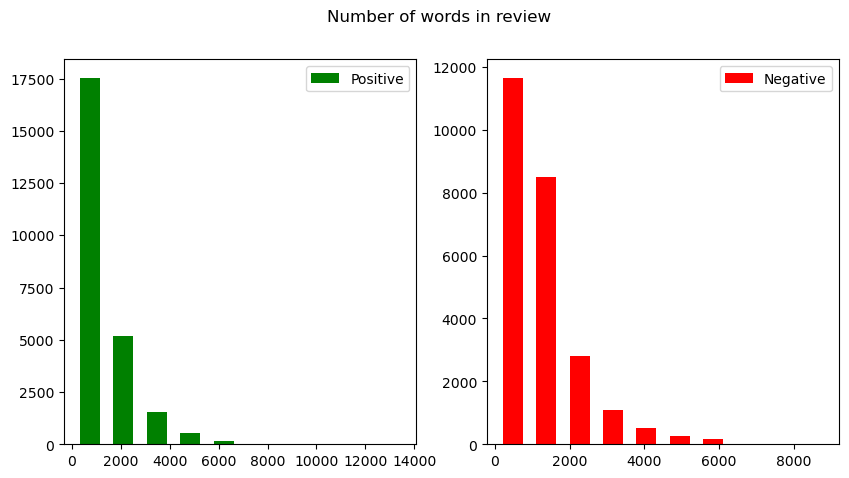

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(df[df['sentiment'] == 'positive']['review'].str.len(), label='Positive', color='green', rwidth=0.6);
ax[0].legend(loc='upper right');
ax[1].hist(df[df['sentiment'] == 'negative']['review'].str.len(), label='Negative', color='red', rwidth=0.6);
ax[1].legend(loc='upper right');
fig.suptitle("Number of words in review")
plt.show()

Let's have a look at one review

In [8]:
df['review'].loc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Let's visualize the most used words for each type of sentiment using word cloud

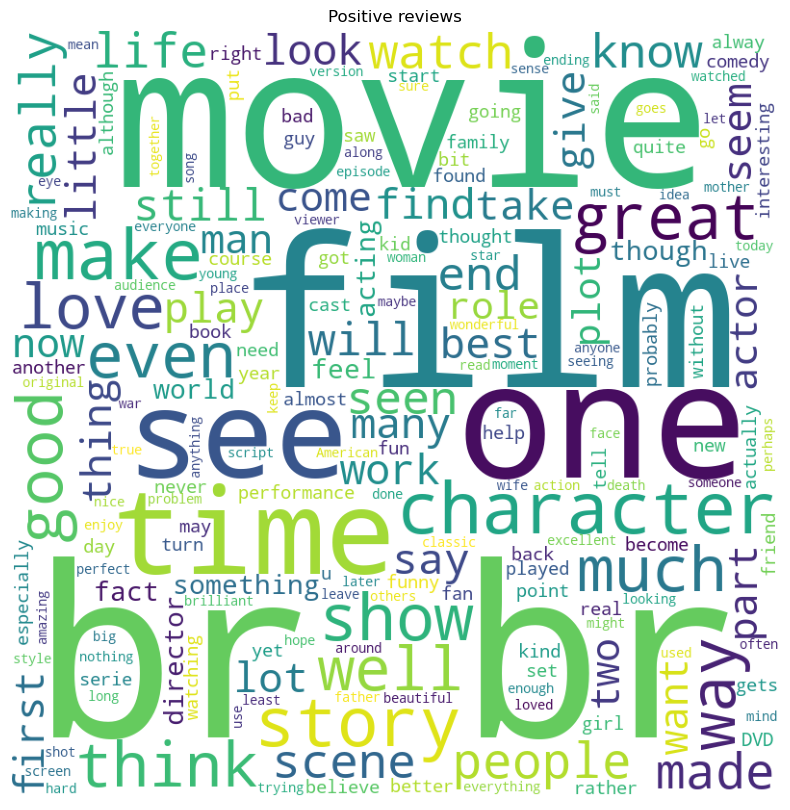

In [9]:
# Most used words in positive reviews

text_review = df ['review']
stopwords = set(STOPWORDS) #build-in list that allows to ignore common irrelevant words like "a", "the", "do", "how", etc.

pos=' '.join(map(str,text_review[df['sentiment']=='positive']))

wordcloud_pos = WordCloud(width = 800, height = 800,
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 12).generate(pos) 

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_pos)
plt.title('Positive reviews')
plt.axis('off')
plt.show() 

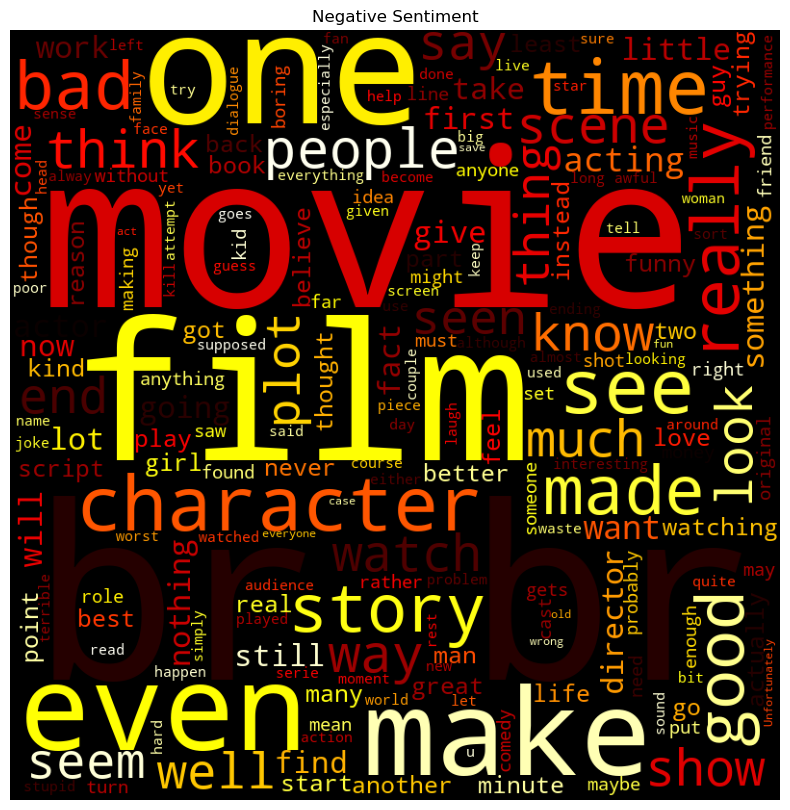

In [10]:
# Most used words in negative reviews

neg=' '.join(map(str,text_review[df['sentiment']=='negative']))

wordcloud_neg = WordCloud(width = 800, height = 800, 
                colormap = 'hot',
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 12).generate(neg) 

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_neg)
plt.title('Negative Sentiment')
plt.axis('off')
plt.show() 

We can see that the most used words contain some html tags ('br'). Also, words like 'film' or 'movie' are very frequent but don't tell much about the sentiment. We will do some cleaning during the data preprocessing.


# Data Preprocessing

**Split each text into multiple sentences and identify the sentences that contains words identified as positive or negative**

In [11]:
import re
import nltk
from nltk.tokenize import sent_tokenize

# Download the positive and negative word lists
nltk.download('opinion_lexicon')

# Get the positive and negative word lists
positive_words = set(nltk.corpus.opinion_lexicon.positive())
negative_words = set(nltk.corpus.opinion_lexicon.negative())

# Print the number of positive and negative words
print(f"Number of positive words: {len(positive_words)}")
print(f"Number of negative words: {len(negative_words)}")

selected_sentences_reviews= []

for i in range(len(df['review'])):
    text = df['review'].loc[i]
    # first we remove all html tags from the text
    text = re.sub("<.*?>", "", text)
    # then we remove multiple occurrences of a punctuation mark, such as ..., with a single occurrence of the same punctuation mark, such as .
    text = re.sub(r'\.+', '. ', text)
    # split the text into sentences
    sentences = sent_tokenize(text)
    # prepare empty lists to identify the sentences conatining positive respective negative words
    positive_word_present = []
    negative_word_present = []
    for i in range(len(sentences)):
        words = word_tokenize(sentences[i].lower())
        positive_word_present.append(bool(set(words) & positive_words)) 
        negative_word_present.append(bool(set(words) & negative_words))
    # Only select the relevant sentences
    sentences_with_positive_word= [x for i, x in enumerate(sentences) if positive_word_present[i]]
    sentences_with_negative_word= [x for i, x in enumerate(sentences) if negative_word_present[i]]
    # Create a unique list with all the selected senetences
    selected_sentences_list = list(set(sentences_with_positive_word + sentences_with_negative_word))
    selected_sentences_reviews.append(' '.join(selected_sentences_list))

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\Zucch\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


Number of positive words: 2006
Number of negative words: 4783


In [12]:
df['review']=np.array(selected_sentences_reviews)

**Remove punctuation, special caracters, uppercase and extra spaces**


In [13]:
df['review'] = df['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))   #clear punctuation
df['review'] = df['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))   #clear special characters
df['review'] = df['review'].apply(lambda x: x.lower())                      #lowercase
df['review'] = df['review'].apply(lambda x: x.strip())                      #clear extra spaces

In [14]:
#df['review'].loc[0]  #uncomment to have a look at a review after this first cleaning

**Remove Stopwords (frequent words that don't give any insight in the sentiment analysis)**

In [15]:
# Let's check the build-in list of Stopwords
import nltk
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))
print(stops)

{"hasn't", 'whom', 'this', "that'll", 'if', 'out', "wouldn't", 'such', 'after', "won't", 'down', "needn't", 'that', 'we', 'its', "you're", "you'll", 'who', 'their', 'them', 'shan', 'own', 'me', 'off', 'm', 'aren', "aren't", 'didn', 'or', 'when', 'what', 'yourselves', 'most', "don't", 'very', 'haven', 'you', 'no', "isn't", 'hers', 'has', 'all', "you'd", 're', 'weren', 'until', 'these', 'll', 'wouldn', 'did', 'her', 'ain', 'had', 'they', "didn't", 'hadn', 'a', 'was', 'because', 'between', 'themselves', 'mightn', 'can', 'won', "doesn't", "you've", 'd', 'his', 'theirs', 'about', 'more', 'before', 'were', 'some', "mustn't", "mightn't", "she's", 'in', 'does', 'not', 'are', 'yourself', 'up', 'on', 'don', 'under', 'once', 'again', 'shouldn', 'too', 'your', "couldn't", "hadn't", 'but', 'against', 'ma', 'our', "wasn't", 'should', 'and', 'he', 's', "shouldn't", 'from', 'ourselves', 'it', 'by', 'to', 'mustn', 'at', 'being', 'is', 'during', 'my', 'been', 'an', 'while', 'herself', 'o', 'y', "weren't

In [16]:
# Add our own custom Stopwords
add_stopwords = ["film", "movie", "character"]
NewStopword = nltk.corpus.stopwords.words('english')
NewStopword.extend(add_stopwords)

In [17]:
# Remove stopwords  #takes 1 min to run
def token(values):
    words = nltk.tokenize.word_tokenize(values)
    filtered_words = [word for word in words if word not in set(NewStopword)]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc
df['review'] = df['review'].apply(lambda x: token(x))

In [18]:
#df['review'].loc[0]  #uncomment to have a look at a review after removing Stopwords

**Apply lemmatization**

In [19]:
# Lemmatization (= stripping the word to its root form, eg. 'working', 'worker', 'works' are transformed into 'work'
lemmatizer = WordNetLemmatizer()

def lemmatize_it(sent):
    empty = []
    for word, tag in pos_tag(word_tokenize(sent)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            lemma = word
            empty.append(lemma)
        else:
            lemma = lemmatizer.lemmatize(word, wntag)
            empty.append(lemma)
    return ' '.join(empty)

In [20]:
df['review'] = df['review'].apply(lemmatize_it) # takes about 7 min to run

**Check cleaned data**

In [21]:
#Let's have a look at a review after the data cleaning
df['review'].loc[0]

'first episode ever saw struck nasty surreal say ready watch developed taste oz get accustomed high level graphic violence oz mess around thats get touch darker side would say main appeal show due fact go show dare focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda hardcore classic use word right exactly happen violence injustice crook guard sell nickel inmate kill order get away well mannered middle class inmate turn prison bitch due lack street skill prison experience watch oz may become comfortable uncomfortable view forget pretty picture paint mainstream audience forget charm forget romance trust show faint hearted timid first thing strike oz brutality unflinching scene violence set right word go scuffle death stare dodgy dealing shady agreement never far away'

In [22]:
# Let's check the word count again. It has reduced by about 50%.
df['word count'] = df['review'].apply(no_of_words)
df.head()

,review,sentiment,word count
0,first episode ever saw struck nasty surreal sa...,positive,128
1,wonderful little production actor extremely we...,positive,86
2,plot simplistic dialogue witty character likab...,positive,76
3,parent divorce argue like real life basically ...,negative,49
4,act good mr mattei direction seem tell us mone...,positive,86


In [23]:
# Let's check the most common words in each category of sentiment

df_pos = df[df.sentiment =='positive']
df_neg = df[df.sentiment =='negative']

count = Counter()
for text in df_pos['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('one', 22880),
 ('like', 19531),
 ('make', 17560),
 ('see', 16182),
 ('well', 15364),
 ('good', 14951),
 ('great', 12930),
 ('time', 12794),
 ('get', 12351),
 ('story', 11621),
 ('love', 11568),
 ('show', 9657),
 ('go', 9427),
 ('watch', 9080),
 ('also', 8943)]

In [24]:
count = Counter()
for text in df_neg['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('like', 23842),
 ('one', 21593),
 ('make', 20514),
 ('see', 15246),
 ('get', 15014),
 ('good', 14647),
 ('bad', 14585),
 ('even', 12535),
 ('well', 12316),
 ('time', 12308),
 ('would', 11500),
 ('go', 11082),
 ('watch', 10835),
 ('really', 10291),
 ('look', 10210)]

In [25]:
df.head()

,review,sentiment,word count
0,first episode ever saw struck nasty surreal sa...,positive,128
1,wonderful little production actor extremely we...,positive,86
2,plot simplistic dialogue witty character likab...,positive,76
3,parent divorce argue like real life basically ...,negative,49
4,act good mr mattei direction seem tell us mone...,positive,86


# Prepare train set and test set

Preprocess the text data by tokenizing the words and converting them to numerical representations

In [44]:
# Tokenize words and convert them to numerical representations
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the tokenizer with a maximum vocabulary size of 10000
tokenizer = Tokenizer(num_words=10000)

# Fit the tokenizer on the texts
tokenizer.fit_on_texts(df['review'])

# Convert the texts to sequences of numerical representations
sequences = tokenizer.texts_to_sequences(df['review'])

# Pad the sequences to a fixed length (in this example, 200)
padded_sequences = pad_sequences(sequences, maxlen=200)



X = padded_sequences
Y = df['sentiment']

print(Y[0])

1


In [45]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build the model

Build an LSTM model that takes in the numerical representations of the text as input and outputs a binary classification of positive or negative sentiment

In [52]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(10000, 128)) #input layer
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid')) #output layer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         1280000   
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


# Fit the model

In [54]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
625/625 [==============================] - 71s 112ms/step - loss: 0.3740 - accuracy: 0.8359 - val_loss: 0.3092 - val_accuracy: 0.8683
Epoch 2/10
625/625 [==============================] - 67s 107ms/step - loss: 0.2400 - accuracy: 0.9088 - val_loss: 0.3023 - val_accuracy: 0.8779
Epoch 3/10
625/625 [==============================] - 68s 109ms/step - loss: 0.1931 - accuracy: 0.9273 - val_loss: 0.3169 - val_accuracy: 0.8694
Epoch 4/10
625/625 [==============================] - 71s 113ms/step - loss: 0.1488 - accuracy: 0.9456 - val_loss: 0.3845 - val_accuracy: 0.8649
Epoch 5/10
625/625 [==============================] - 72s 115ms/step - loss: 0.1195 - accuracy: 0.9584 - val_loss: 0.4126 - val_accuracy: 0.8635
Epoch 6/10
625/625 [==============================] - 73s 116ms/step - loss: 0.0987 - accuracy: 0.9669 - val_loss: 0.4336 - val_accuracy: 0.8630
Epoch 7/10
625/625 [==============================] - 74s 118ms/step - loss: 0.0656 - accuracy: 0.9776 - val_loss: 0.5389 - val_ac

# Evaluate model

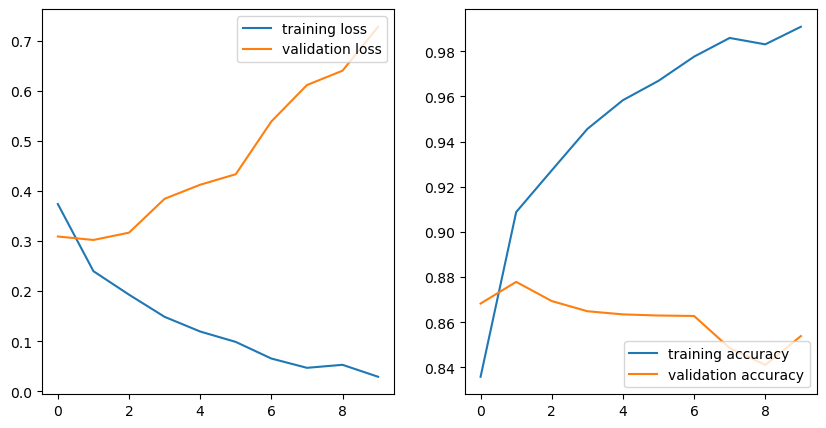

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [56]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print ('Test loss:', test_loss)
print ('Test accuracy:', test_acc)

313/313 [==============================] - 7s 22ms/step - loss: 0.7280 - accuracy: 0.8539
Test loss: 0.7279900312423706
Test accuracy: 0.8539000153541565


We achieve an accuracy of 88% but the model is massively overfitting.  How can we prevent this ? Is there an issue with the model or in the data preprocessing ?